# 🕳️G2Net - EDA & Signal Transformations

### Other notebooks in the competition
- [G2Net Keras baseline [Training]](https://www.kaggle.com/ammarnassanalhajali/g2net-keras-baseline-training)
- [G2Net Keras baseline [Inference]](https://www.kaggle.com/ammarnassanalhajali/g2net-keras-baseline-inference)


# Introduction


* **A black hole** is a region of spacetime where gravity is so strong that nothing—no particles or even electromagnetic radiation such as light—can escape from it.
* **G2Net** is a network of Gravitational Wave, Geophysics and Machine Learning. Via an Action from COST (European Cooperation in Science and Technology), a funding agency for research and innovation networks, G2Net aims to create a broad network of scientists. From four different areas of expertise, namely GW physics, Geophysics, Computing Science and Robotics, these scientists have agreed on a common goal of tackling challenges in data analysis and noise characterization for GW detectors.
* **Competition Goal** is to detect GW signals from the mergers of binary black holes. Specifically, you'll build a model to analyze simulated GW time-series data from a network of Earth-based detectors.

# Data Description
* In this competition you are provided with a training set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo)

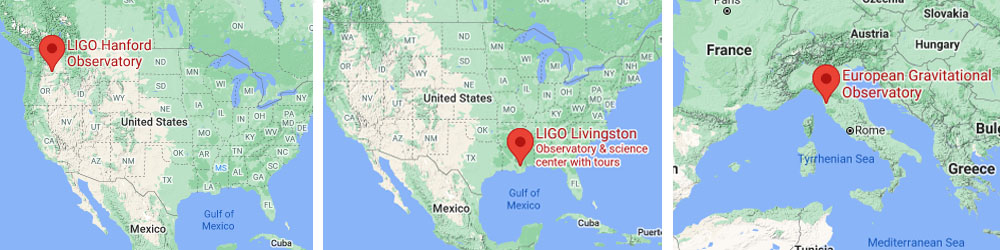

* The **Laser Interferometer Gravitational-Wave Observatory** (LIGO) is a large-scale physics experiment and observatory designed to detect cosmic gravitational waves and to develop gravitational-wave observations as an astronomical tool

### LIGO Hanford
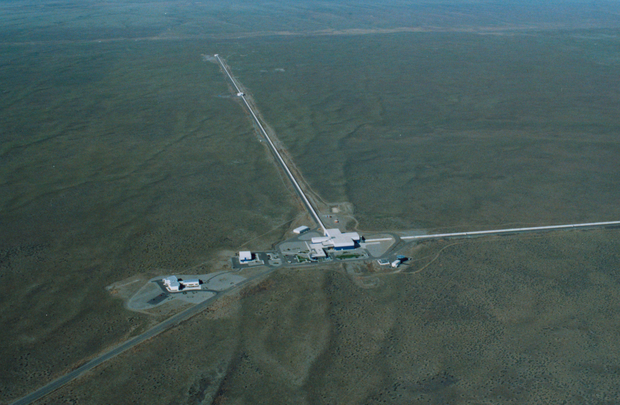

* Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal. The task is to identify when a signal is present in the data (target=1).
* Each data sample (npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

# importing Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import json
import random
import collections

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

# Files
* **train** - the training set files, one npy file per observation
* **test** - the test set files; you must predict the probability that the observation contains a gravitational wave
* **training_labels.csv** - target values of whether the associated signal contains a gravitational wave
* **sample_submission.csv** - a sample submission file in the correct format

# Loading Data

In [ ]:
train_df = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
train_df.head(5)

In [ ]:
db_sample=train_df.head(n=2)
db_sample

In [ ]:
sns.countplot(data=train_df, x="target")

In [ ]:
def get_train_file_path(image_id):
    return "../input/g2net-gravitational-wave-detection/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)



train_df['path'] = train_df['id'].apply(get_train_file_path)
train_df.head(5)

# A Kernel Density Estimate (KDE) 

In [ ]:
def get_npy_df(path):
    df = pd.DataFrame({"LIGO Hanford" : np.load(path)[0],
                       "LIGO Livingston" : np.load(path)[1],
                       "Virgo" : np.load(path)[2]})
    
    return df

In [ ]:
no_target = list(train_df.loc[train_df["target"] == 0, "path"])[23]
no_target = get_npy_df(path = no_target)

yes_target = list(train_df.loc[train_df["target"] == 1, "path"])[23]
yes_target = get_npy_df(path = yes_target)

# Plot
fig = plt.figure(figsize=(25, 10))

outer = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.2)

signal_names = ["LIGO Hanford", "LIGO Livingston", "Virgo"]
colors = ["#f99e97", "#55d07a", "#69a1ff"]

for i, site, col in zip(range(3), signal_names, colors):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                                             subplot_spec=outer[i], 
                                             wspace=0.1, hspace=0.1,
                                             height_ratios= (.20, .80))
    ax1 = plt.Subplot(fig, inner[0,0])
    ax2 = plt.Subplot(fig, inner[1,0])
    
    mean0 = no_target[site].mean()
    
    sns.boxplot(no_target[site], ax=ax1, color=col)
    sns.kdeplot(data=no_target, x=site, ax=ax2, color=col, shade=True,lw=2, alpha=0.5)
    ax2.axvline(x=mean0, color=col, lw=1, ls="--")
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)

    ax1.set(title='Target=0')
    ax1.set(xlabel='')
    axs = [ax1, ax2]
    for ax in axs:
        ax.set_xticks([])
        ax.set_ylabel("")
    sns.despine(bottom=True, left=True)

for i, site, col  in zip(range(3), signal_names, colors):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                                             subplot_spec=outer[i], 
                                             wspace=0.1, hspace=0.1,
                                             height_ratios= (.20, .80))
    ax1 = plt.Subplot(fig, inner[0,1])
    ax2 = plt.Subplot(fig, inner[1,1])
    
    mean1 = yes_target[site].mean()
    
    sns.boxplot(yes_target[site], ax=ax1, color=col)
    sns.kdeplot(data=yes_target, x=site, ax=ax2, color=col, shade=True,lw=2, alpha=0.5)
    ax2.axvline(x=mean1, color=col, lw=1, ls="--")
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)
    ax1.set(title='Target=1')
    
    ax1.set(xlabel='')
    axs = [ax1, ax2]
    for ax in axs:
        ax.set_xticks([])
        ax.set_ylabel("")
    sns.despine(bottom=True, left=True)

#  Example Time Series - Target vs No Target

In [ ]:
def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [ ]:
colors=("#f99e97", "#55d07a", "#69a1ff")
signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")

fig, axs = plt.subplots(3, 2,figsize=(18, 8))
j=0
for i in db_sample.index.tolist():
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    for i in range(3):
        if i==0:
             axs[i, j].set_title(f"id: {_id} ---  Target: {target}", fontsize=15)
        axs[i, j].plot(x[i], color=colors[i])
        axs[i, j].legend([signal_names[i]], fontsize=12, loc="lower right")
    j=j+1

# Signal Transformations
### 1-Spectrogram
* **A spectrogram** is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.


In [ ]:
import librosa
import librosa.display

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(19, 12))
j=0
for i in db_sample.index.tolist():
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    for i in range(3):
        X = librosa.stft(x[i] / x[i].max())
        Xdb = librosa.amplitude_to_db(abs(X))
        img=librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-30, vmax=50, ax=axs[i, j])       
        if i==0:
             axs[i, j].set_title(f"id: {_id} ---  Target: {target}", fontsize=15)
        axs[i, j].plot(0)
        axs[i, j].legend([signal_names[i]], fontsize=10, loc="lower right") 
        fig.colorbar(img, ax=axs[i, j])
    j=j+1
    

### 2-MFCCs
Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum").

In [ ]:
sr=2048
fig, axs = plt.subplots(3, 2, figsize=(19, 12))
j=0
for i in db_sample.index.tolist():
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    for i in range(3):
        mfccs = librosa.feature.mfcc(x[i] / x[i].max(), sr=sr)
        img=librosa.display.specshow(mfccs, sr=sr, x_axis="time", vmin=-200, vmax=50, cmap="coolwarm", ax=axs[i, j])       
        if i==0:
             axs[i, j].set_title(f"id: {_id} ---  Target: {target}", fontsize=15)
        axs[i, j].plot(0)
        axs[i, j].legend([signal_names[i]], fontsize=10, loc="lower right") 
        fig.colorbar(img, ax=axs[i, j])
    j=j+1

### 3- Constant-Q transform
In mathematics and signal processing, **the constant-Q transform** transforms a data series to the frequency domain. It is related to the Fourier transform and very closely related to the complex Morlet wavelet transform

In [ ]:
!pip install -q nnAudio -qq
import torch
from nnAudio.Spectrogram import CQT1992v2

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(19, 12))
j=0
Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=32)
for i in db_sample.index.tolist():
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    for i in range(3):
        waves = x[i] / np.max(x[i])
        waves = torch.from_numpy(waves).float()
        image = Q_TRANSFORM(waves)
        axs[i, j].imshow(image.squeeze())
        if i==0:
             axs[i, j].set_title(f"id: {_id} ---  Target: {target}", fontsize=15)
        axs[i, j].plot(0)
        axs[i, j].legend([signal_names[i]], fontsize=10, loc="lower right") 
    j=j+1

# Two-dimensional spectrograms

In [ ]:
# Define the list of frequencies
frequencies= np.arange(0,1000,1)

# Sampling Frequency
samplingFrequency   = 2048

fig, axs = plt.subplots(3, 2, figsize=(19, 12))
j=0
for i in db_sample.index.tolist():
    _id = train_df.iloc[i]["id"]
    target = train_df.iloc[i]["target"]
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    for i in range(3):
        for frequency in frequencies:
            # Signal - Sine wave with varying frequency + Noise
            sub2 = np.sin(2*np.pi*x[i]*frequency*1/samplingFrequency)#+np.random.randn(len(sub1))
        
        powerSpectrum, freqenciesFound, time, imageAxis = axs[i, j].specgram(sub2, Fs=samplingFrequency)
        axs[i, j].set_xlabel('Time')
        axs[i, j].set_ylabel('Frequency Hz')
        axs[i, j].set_xlim([0.1, 1.9])
        axs[i, j].plot(0)
        axs[i, j].legend([signal_names[i]])
        fig.colorbar(imageAxis, ax=axs[i, j]).set_label('Amplitude[dB]')
        if i==0:
             axs[i, j].set_title(f"id: {_id} ---  Target: {target}", fontsize=15)

    j=j+1

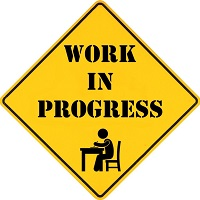

1. https://en.wikipedia.org/wiki/Black_hole
1. https://www.kaggle.com/ihelon/g2net-eda-and-modeling
1. https://www.kaggle.com/andradaolteanu/g2net-searching-the-sky-eda
1. https://www.kaggle.com/headsortails/when-stars-collide-g2net-eda
1. https://pnsn.org/spectrograms/what-is-a-spectrogram#:~:text=A%20spectrogram%20is%20a%20visual,energy%20levels%20vary%20over%20time.